In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [7]:
bins = [np.concatenate([np.linspace(75, 82, 10),np.linspace(82.1, 92, 100), np.linspace(92.1, 125, 10)]), np.concatenate([np.linspace(-75, -10, 10),np.linspace(-9.9, 5, 100), np.linspace(5.1, 75, 10)])]
X, Y = np.meshgrid(bins[0], bins[1])

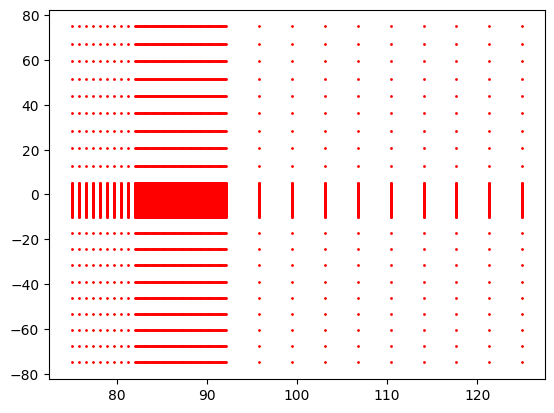

In [8]:
plt.scatter(X, Y, c='r', s=1)

In [15]:
bins = [np.concatenate([np.linspace(0.01, 0.29, 10),np.linspace(0.3, 0.4, 20), np.linspace(0.41, 0.7, 10)])]
bin_centers = (bins[0][1:] + bins[0][:-1]) / 2
bins

[array([0.01      , 0.04111111, 0.07222222, 0.10333333, 0.13444444,
        0.16555556, 0.19666667, 0.22777778, 0.25888889, 0.29      ,
        0.3       , 0.30526316, 0.31052632, 0.31578947, 0.32105263,
        0.32631579, 0.33157895, 0.33684211, 0.34210526, 0.34736842,
        0.35263158, 0.35789474, 0.36315789, 0.36842105, 0.37368421,
        0.37894737, 0.38421053, 0.38947368, 0.39473684, 0.4       ,
        0.41      , 0.44222222, 0.47444444, 0.50666667, 0.53888889,
        0.57111111, 0.60333333, 0.63555556, 0.66777778, 0.7       ])]